In [43]:
import numpy as np
import shapely as sh
from uuid import uuid4
from sys import modules
from time import perf_counter
from rebound import Simulation
import scipy.constants as const
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from multiprocessing.pool import Pool

def globalize(func):
    def result(*args, **kwargs):
        return func(*args, **kwargs)
    result.__name__ = result.__qualname__ = uuid4().hex
    setattr(modules[result.__module__], result.__name__, result)
    return result

def timeit(f, *args, **kwargs):
    start = perf_counter()
    f(*args, **kwargs)
    end = perf_counter()
    time = end-start
    print(f"Elapsed time = {time}s")
    
def HW99(mu: float, e: float, a_b: float) -> float:
    return (1.6+4.12*mu+5.1*e-4.27*mu*e
            -2.22*e**2-5.09*mu**2+4.61*e**2*mu**2)*a_b

In [59]:
def init(M_A: float, M_B: float, a_bin: float, a_p: float, 
         inc_bin: float, Omega_bin:float, inc_p: float, Omega_p: float,
         e_B: float = 0, e_p: float = 0, omega: float = 0) -> Simulation:
    """Returns a Simulation object of all 3 objects in the system.
    
    Parameter
    ---------
    M_A : float
        Mass of star A (solar masses)
    M_B : float
        Mass of star B (solar masses)
    a_bin : float
        Semi-major axis of binary (AU)
    a_p : float
        Semi-major axis of planet (AU)
    inc_bin : float
        Inclination of binary (rad)
    Omega_bin : float
        Longitude of ascending node of binary (rad)
    inc_p : float
        Inclination of planet (rad)
    Omega_p : float
        Longitude of ascending node of planet (rad)
    e_B : float (default 0.0)
        Orbital eccentricity of binary
    e_p : float (default 0.0)
        Orbital eccentricity of planet
    omega : float (default 0.0)
        Argument of pericenter (rad)
    """
    sim = Simulation()
    sim.add(m=M_A)
    sim.add(m=M_B, a=a_bin, inc=inc_bin, 
            Omega=Omega_bin, e=e_B, omega=omega)
    sim.add(a=a_p, inc=inc_p, Omega=Omega_p, e=e_p)
    sim.move_to_com()
    return sim

def integrate(sim: Simulation, N_orbits: float = 1) -> tuple[np.array]:
    """Returns arrays of the x and y coordinates of the particles 
    in the Simulation object after being integrated over 'Norbits' 
    planet orbits.
    
    Parameter
    ---------
    sim : Simulation
        Simulation object
    Norbits : float (default 1.0)
        Number of planet orbits to plot
    """
    N_STEPS = 1000
    P = sim.calculate_orbits()[1].P
    T = np.linspace(0, N_orbits*P, N_STEPS)
    x = np.zeros((sim.N, N_STEPS))
    y = np.zeros_like(x)
    z = np.zeros_like(x)
    for i, t in enumerate(T):
        sim.integrate(t)
        for j in range(sim.N):
            z[j,i] = _z = sim.particles[j].z
            #if _z < 0 and j == 2 :
                #x[j,i], y[j,i] = np.NaN, np.NaN 
            #else:
            x[j,i] = sim.particles[j].x
            y[j,i] = sim.particles[j].y
    return x, y, z

def plot(sim: Simulation, x: np.array, y: np.array) -> None:
    """Returns None and plots the orbits.

    Parameter
    ---------
    sim : Simulation
        Simulation object
    x: np.array
        x-coordinates of the bodies in the system
    y: np.array
        y-coordinates of the bodies in the system
    """

    fig , ax = plt.subplots()
    for n in range(sim.N):
        ax.plot(x[n], y[n])
    ax.set_title("View of the System along the z-axis")
    ax.set_xlabel("x-coordinate")
    ax.set_ylabel("y-coordinate")
    plt.grid(True)
    
def plot_system(M_A: float, M_B: float, a: float, r_a: float, 
                inc: float, Omega:float = 0, e: float = 0, 
                omega: float = 0, N: float = 1, dinc: float = 0) ->  None:
    """Returns None and plots the orbits.
    
    Parameter
    ---------
    M_A : float
        Mass of star A (solar masses)
    M_B : float
        Mass of star B (solar masses)
    a : float
        Semi-major axis of binary (AU)
    r_a : float
        Ratio of the planet's semi-major axis 
        and the binary's semi-major axis
    inc : float
        Inclination of binary (rad)
    Omega : float (default 0.0)
        Longitude of ascending node of binary (rad)
    e : float (default 0.0)
        Orbital eccentricity of binary
    omega : float (default 0.0)
        Argument of pericenter (rad)
    N : float (default 1.0)
        Orbital eccentricity of planet
    """
    sim = init(M_A, M_B, a, r_a*a, inc, 
               Omega, inc+dinc, Omega, e, omega=omega)
    x, y, z = integrate(sim, N)  
    plot(sim, x, y)
    plt.show()
    
##############################################################################
'''    coords = np.transpose(np.array([[x[i], y[i]] for i in range(x.shape[0])]), axes=(0,2,1))
    ringA = sh.LinearRing(coords[0])
    ringB = sh.LinearRing(coords[1])
    ringP = sh.LinearRing(coords[2])
    #print(sh.distance(ringA, ringP), sh.distance(ringB, ringP))'''
##############################################################################
    
def check_transit(R_A: float, R_B: float, R_p: float, 
                  x: np.array, y: np.array) -> int:
    """Returns an int corresponding the number of stars 
    in the binary that the planet transits.

    Parameter
    ---------
    R_A : float
        Radius of star A (AU)
    R_B : float
        Radius of star B (AU)
    R_p : float
        Radius of planet (AU)
    x : np.array
        x-coordinates of the bodies in the system
    y : np.array
        y-coordinates of the bodies in the system
    """
    coords = np.transpose(
        np.array([[x[i], y[i]] for i in range(x.shape[0])]), axes=(0,2,1))
    ringA = sh.LinearRing(coords[0])
    ringB = sh.LinearRing(coords[1])
    #stringP = coords[2][~np.isnan(coords[2])]
    #stringP = np.split(stringP, stringP.size/2)
    #stringP = sh.LineString(stringP)
    #print(coords[2][~np.isnan(coords[2])].shape)
    ringP = sh.LinearRing(coords[2])
    #x, y = np.array(stringP.coords).T
    #plt.plot(x, y)
    return int(sh.dwithin(ringA, ringP, R_A+R_p)) + int(sh.dwithin(ringB, ringP, R_B+R_p))
    
def transit_plot(r_A: float, r_B: float, r_p: float, I_range: tuple, 
                 a_r_range: tuple, a: float = 1, M: float = 1, mu: float = 1, 
                 Omega: float = 0, e: float = 0, omega: float = 0) -> None:
    """Returns None and creates a plot of the transit function over 
    the domain of the inclination range and the semi-major axis ratio range.
    
    Parameter
    ---------
    r_A : float
        Radius of star A (AU)
    r_B : float
        Radius of star B (AU)
    r_p : float
        Radius of planet (AU)
    I_range : tuple[float]
        Inclination range of system (rad)
    a_r_range : tuple[float]
        Ratio of the planet's semi-major axis 
        and the binary's semi-major axis
    a : float (default 1.0)
        Semi-major axis of binary (AU)
    M : float (default 1.0)
        Mass of star A (solar masses)
    mu : float (default 1.0)
        Mass ratio between stars
    Omega : float (default 0.0)
        Longitude of ascending node of system (rad)
    e : float (default 0.0)
        Orbital eccentricity of planet
    omega : float (default 0.0)
        Argument of pericenter (rad)
    """
    I = np.arange(*I_range)
    ratio = np.arange(*a_r_range)
    args = np.array(np.meshgrid(I, ratio)).T.reshape(-1,2)
    
    @globalize
    def process(i, r) -> int:
        i += 90
        a_critical = HW99(1/(1+mu), e, a)
        if a_critical > a*r:
            return -1
        sim = init(M, mu*M, a, a*r, i*np.pi/180, Omega*np.pi/180, 
           i*np.pi/180, Omega*np.pi/180, e_B=e, omega=90*np.pi/180)
        x, y, z = integrate(sim, 1)
        
        return check_transit(r_A, r_B, r_p, x, y)
        
    results = np.array([]);
    with Pool() as pool:
        for result in pool.starmap(process, args):
            results = np.append(results, result);
            
    def fit(grid: np.array, x: np.array, y: np.array, R: float) -> None:
        def curve(r, A):
            return A*R/r
        boundary = np.empty((0,2))
        for i, col in enumerate(grid.T):
            steps = 0
            for j, val in enumerate(col):
                if val:
                    steps += 1
            if not steps or steps==col.size:
                continue
            point = np.array([[x[i], y[steps-1]]])
            boundary = np.concatenate((boundary, point))
        _x, _y = boundary.T[0], boundary.T[1]
        popt, pcov = curve_fit(curve, _x, _y)
        plt.plot(x, curve(x, *popt), c='k')
        print(popt, np.sqrt(np.diag(pcov)))

    transits = np.array(results).reshape(I.size, ratio.size)
    fig, ax = plt.subplots()
    cmap = colors.ListedColormap(['grey', 'red', 'orange', 'green'])
    boundaries = [-1.5, -0.5, 0.5, 1.5, 2.5]
    norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)
    ax.pcolormesh(ratio, I, transits, cmap=cmap, norm=norm)
    # fit(transits, ratio, I, r_A+r_B) # work in progress
    plt.ylim(I.min(), I.max())
    plt.xlabel('$a_p/a_b$')
    plt.ylabel('$I\ (^\circ)$')
    description = f'$e=${e}\n$\omega$={omega}$^\circ$'
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(0.05, 0.95, description, transform=ax.transAxes, fontsize=12,
         verticalalignment='top', bbox=props)
    plt.show()

35.5430635052669


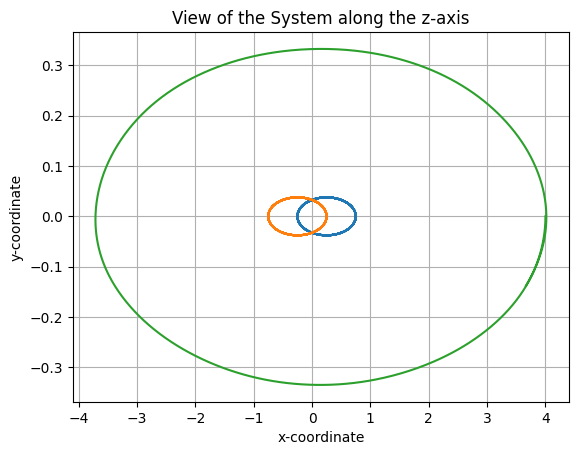

0.29490580890873724 0.2929209651975266
35.54306350526696


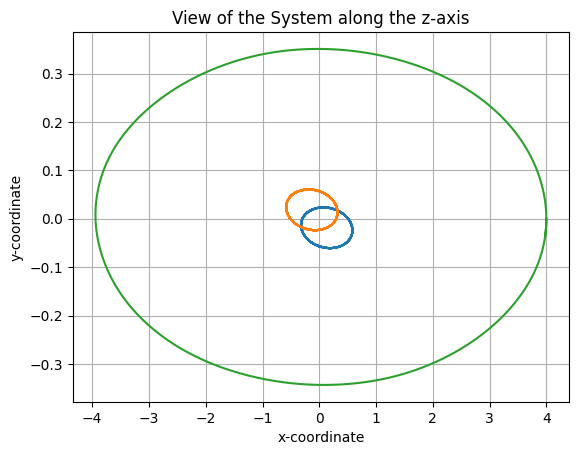

0.28238397457048064 0.2898745670912613


In [39]:
plot_system(1, 1, 1, 4, (90+5)*np.pi/180, e=0.5, omega=0)
plot_system(1, 1, 1, 4, (90+5)*np.pi/180, e=0.5, omega=45)

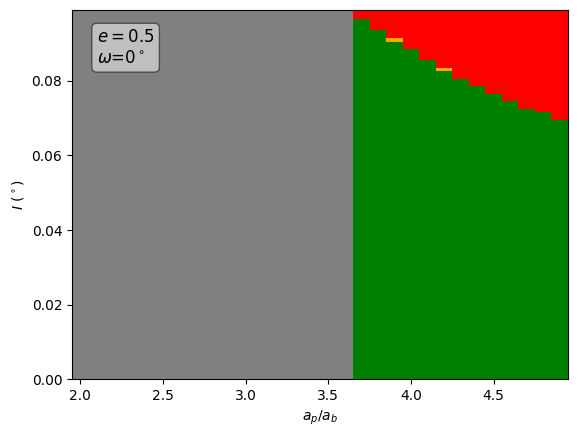

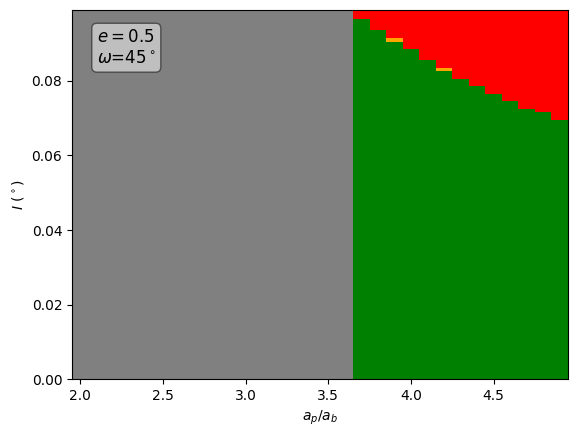

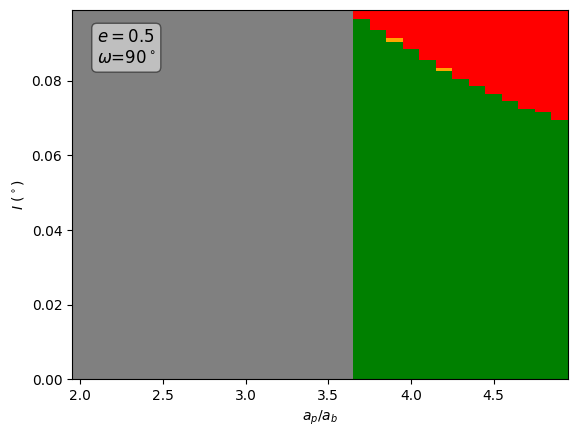

In [54]:
# Example plot
transit_plot(0.005, 0.005, 5e-5, (0, 0.1, 0.001), (2, 5, 0.1), e=0.5, omega=0)
transit_plot(0.005, 0.005, 5e-5, (0, 0.1, 0.001), (2, 5, 0.1), e=0.5, omega=45)
transit_plot(0.005, 0.005, 5e-5, (0, 0.1, 0.001), (2, 5, 0.1), e=0.5, omega=90)

In [58]:
def Ptoa(P_p, M_A, M_B):
    #C = 4*np.pi**2/const.G*(M_A+M_B)
    return np.cbrt((M_A+M_B)*(P_p/2/np.pi/365)**2)

def atoP(a_p, M_A, M_B):
    #C = 4*np.pi**2/const.G*(M_A+M_B)
    return 2*np.pi*np.sqrt(a_p**3/(M_A+M_B))*365

def initialize(M_A, M_B, P_b, inc, a_p):
    a_b = Ptoa(P_b, M_A, M_B)
    a_c = HW99(M_B/(M_A+M_B), 0, a_b)
    P_c = atoP(a_c, M_A, M_B)
    print(a_b, a_c, P_c)
    
    sim = Simulation()
    sim.add(m=M_A)
    sim.add(m=M_B, a=a_b, inc=inc)
    sim.add(a=a_p, inc=inc)
    sim.move_to_com()
    #return sim

initialize(1, 1, 25, 0, 6)

0.06194242197617252 0.1478875324681119 92.22636230653832


<rebound.simulation.Simulation object at 0x7fbcf9262040, N=3, t=0.0>

In [ ]:
'''
debug using plots
uniform in log inner most orbit (100 days) stable to 1-2 AU



'''